In [1]:
import sys
from pathlib import Path

sys.path.append(r"/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.lines as mlines
from linearmodels.panel import PanelOLS
from io import StringIO
from sklearn.preprocessing import StandardScaler


from data_analysis.data_fetcher.data_fetcher_class import DataFetcher
from data_collection.consts import  DB_PARAMS

In [2]:
fetcher = DataFetcher(
    db_params=DB_PARAMS,
    reports_table="reports_2",
    targets_table="targets_yf",
)

Available regressors:
 - avg_default_verbolizer
 - avg_shrink_verbolizer
 - doc_len
 - eps_surprise
 - f_size
 - full_list_default_verbolizer
 - full_list_shrink_verbolizer
 - hv_orig_score
 - lm_orig_score
 - max_abs_default
 - max_abs_shrink
 - max_default_verbolizer
 - max_shrink_verbolizer
 - md_hv1
 - md_hv2
 - md_hv3
 - md_lm1
 - md_lm2
 - md_lm3
 - min_default_verbolizer
 - min_shrink_verbolizer
 - stretch_default
 - stretch_shrink
Available sectors:
 - Technology (92)
 - Industrials (86)
 - Financial Services (85)
 - Healthcare (66)
 - Consumer Cyclical (58)
 - Consumer Defensive (40)
 - Real Estate (32)
 - Utilities (32)
 - Energy (30)
 - Basic Materials (23)
 - Communication Services (22)


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [3]:
df_q = fetcher.fetch_data(
    regressors=[
        'stretch_shrink',
        'eps_surprise',
        'f_size',
        'doc_len'
        ],
    report_filters={'report_type' : ['10-K']},
       prepare_fixed_effects=True,
    )

/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:130: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


Expanding list regressor 'stretch_shrink' into 107 columns...


/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:161: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, conn)
/home/maxim-shibanov/Projects_Py/Risk-and-return-prediction-with-LLM/src/data_analysis/data_fetcher/data_fetcher_class.py:169: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  companies_df = pd.read_sql_query(query, conn)


In [4]:
class FEModeler:
    def __init__(self, df: pd.DataFrame, scale: bool = False):
        self.original_df = df.copy()
        self.df = df.copy()
        self.var_names = df.columns
        self.params_dict = {}
        self.scale = scale

        if scale:
            self._scale_regressors()

    def _scale_regressors(self):
        x_cols = list(self.df.columns[4:111]) + ['eps_surprise', 'f_size']
        scaler = StandardScaler()
        for entity in self.df.index.get_level_values(0).unique():
            entity_mask = self.df.index.get_level_values(0) == entity
            sub_df = self.df.loc[entity_mask, x_cols]
            if sub_df.shape[0] < 2:
                continue
            self.df.loc[entity_mask, x_cols] = scaler.fit_transform(sub_df)

    @staticmethod
    def extract_params(summary, regressor_name: str) -> pd.Series:
        coef_table = summary.tables[1].as_html()
        coef_table_io = StringIO(coef_table)
        df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
        df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
        return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

    def fit(self, data: pd.DataFrame, formula: str):
        model = PanelOLS.from_formula(formula, data=data, check_rank=False)
        result = model.fit(cov_type='kernel')
        return result.summary
    
    @staticmethod
    def try_convert_numeric(col):
        try:
            return pd.to_numeric(col)
        except Exception:
            return col

    def compute(self) -> dict[str, dict[str, dict[str, pd.Series]]]:
        targets = ['returns', 'e_returns', 'abn_returns', 'r_vol']
        time_frames = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter']
        var_names = self.df.columns

        for target in targets:
            if target not in self.params_dict:
                self.params_dict[target] = {}

            for frame in time_frames:
                if frame not in self.params_dict[target]:
                    self.params_dict[target][frame] = {}

                y = 111 + targets.index(target) * 7 + time_frames.index(frame)

                for x in range(4, 111):  # All 107 regressors
                    reg_name = var_names[x]
                    dep_name = var_names[y]
                    print(reg_name, dep_name)

                    data = self.df.iloc[:, [0, 1, 2, 3, x, y]].dropna().copy()
                    data = data.apply(self.try_convert_numeric)

                    formula = f"{dep_name} ~ {reg_name} + f_size + eps_surprise + doc_len + C(report_type) + EntityEffects + TimeEffects"

                    try:
                        result_summary = self.fit(data, formula)
                        param_info = self.extract_params(result_summary, reg_name)
                        self.params_dict[target][frame][reg_name] = param_info
                    except Exception as e:
                        print(f"Regression failed for {reg_name} ~ {dep_name}: {e}")

        return self.params_dict

    def plot_all_params(self,
                        save: bool = False,
                        save_dir: str = "plots",
                        fmt: str = "png",
                        dpi: int = 300):
        """
        For each (target, timeframe) pair in `self.params_dict`, plot all 107
        regressor coefficients with 95 % CI bars.
    
        Parameters
        ----------
        save : bool, default False
            If True, each figure is written to `save_dir` instead of (or in
            addition to) being shown interactively.
        save_dir : str, default "plots"
            Directory into which files are written. Created automatically when
            absent.
        fmt : str, default "png"
            Any Matplotlib-supported backend (png, pdf, svg, etc.).
        dpi : int, default 300
            Output resolution for raster formats.
        """
        # ensure output folder exists if saving
        if save:
            Path(save_dir).mkdir(parents=True, exist_ok=True)
    
        for target, frame_dict in self.params_dict.items():
            for frame, reg_dict in frame_dict.items():
                if not reg_dict:           # skip empty entries
                    continue
                
                regs   = list(reg_dict.keys())
                x      = np.arange(len(regs))
                params = [reg_dict[r]["Parameter"] for r in regs]
                lower  = [reg_dict[r]["Lower CI"] for r in regs]
                upper  = [reg_dict[r]["Upper CI"] for r in regs]
    
                plt.figure(figsize=(18, 6))
                plt.bar(x, params, width=0.6, color="tab:blue", label="Coefficient")
    
                for i in range(len(regs)):
                    plt.plot([x[i], x[i]], [lower[i], upper[i]], color="black", linewidth=1)
    
                plt.axhline(0, color="black", linewidth=1)
                plt.xticks(x, regs, rotation=90, fontsize=8)
                plt.title(f"Fixed Effects Coefficients for {target} – {frame}")
                plt.xlabel("Regressors")
                plt.ylabel("Coefficient")
                plt.tight_layout()
    
                ci_legend = mlines.Line2D([], [], color="black", linewidth=1.5, label="95% CI")
                plt.legend(handles=[ci_legend])
    
                # ---------- Persist to disk ----------
                if save:
                    # make filename safe for any OS
                    safe_target = re.sub(r"[^A-Za-z0-9_-]+", "_", str(target))
                    safe_frame  = re.sub(r"[^A-Za-z0-9_-]+", "_", str(frame))
                    fname = f"{safe_target}_{safe_frame}.{fmt}"
                    out_path = Path(save_dir) / fname
                    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
                # -------------------------------------
    
                plt.show()
    

In [5]:
df_q['f_size'] = df_q['f_size'] / 10**11

In [6]:
model = FEModeler(df=df_q, scale=True)
res = model.compute()

segment_1 two_day_r
segment_2 two_day_r
segment_3 two_day_r
segment_4 two_day_r
segment_5 two_day_r
segment_6 two_day_r
segment_7 two_day_r
segment_8 two_day_r
segment_9 two_day_r
segment_10 two_day_r
segment_11 two_day_r
segment_12 two_day_r
segment_13 two_day_r
segment_14 two_day_r
segment_15 two_day_r
segment_16 two_day_r
segment_17 two_day_r
segment_18 two_day_r
segment_19 two_day_r
segment_20 two_day_r
segment_21 two_day_r
segment_22 two_day_r
segment_23 two_day_r
segment_24 two_day_r
segment_25 two_day_r
segment_26 two_day_r
segment_27 two_day_r
segment_28 two_day_r
segment_29 two_day_r
segment_30 two_day_r
segment_31 two_day_r
segment_32 two_day_r
segment_33 two_day_r
segment_34 two_day_r
segment_35 two_day_r
segment_36 two_day_r
segment_37 two_day_r
segment_38 two_day_r
segment_39 two_day_r
segment_40 two_day_r
segment_41 two_day_r
segment_42 two_day_r
segment_43 two_day_r
segment_44 two_day_r
segment_45 two_day_r
segment_46 two_day_r
segment_47 two_day_r
segment_48 two_day_r
s

In [7]:
for key in res:
    print(key, '\n', res[key], '\n\n\n')

returns 
 {'2_day': {'segment_1': Parameter   -0.0004
std_err      0.0242
P-value      0.9874
Lower CI    -0.0479
Upper CI     0.0471
Name: segment_1, dtype: float64, 'segment_2': Parameter    0.0003
std_err      0.0243
P-value      0.9912
Lower CI    -0.0474
Upper CI     0.0479
Name: segment_2, dtype: float64, 'segment_3': Parameter   -0.0123
std_err      0.0218
P-value      0.5717
Lower CI    -0.0550
Upper CI     0.0304
Name: segment_3, dtype: float64, 'segment_4': Parameter   -0.0061
std_err      0.0261
P-value      0.8146
Lower CI    -0.0573
Upper CI     0.0451
Name: segment_4, dtype: float64, 'segment_5': Parameter    0.0065
std_err      0.0207
P-value      0.7536
Lower CI    -0.0341
Upper CI     0.0471
Name: segment_5, dtype: float64, 'segment_6': Parameter   -0.0158
std_err      0.0274
P-value      0.5633
Lower CI    -0.0695
Upper CI     0.0378
Name: segment_6, dtype: float64, 'segment_7': Parameter   -0.0462
std_err      0.0234
P-value      0.0480
Lower CI    -0.0920
Upper CI  

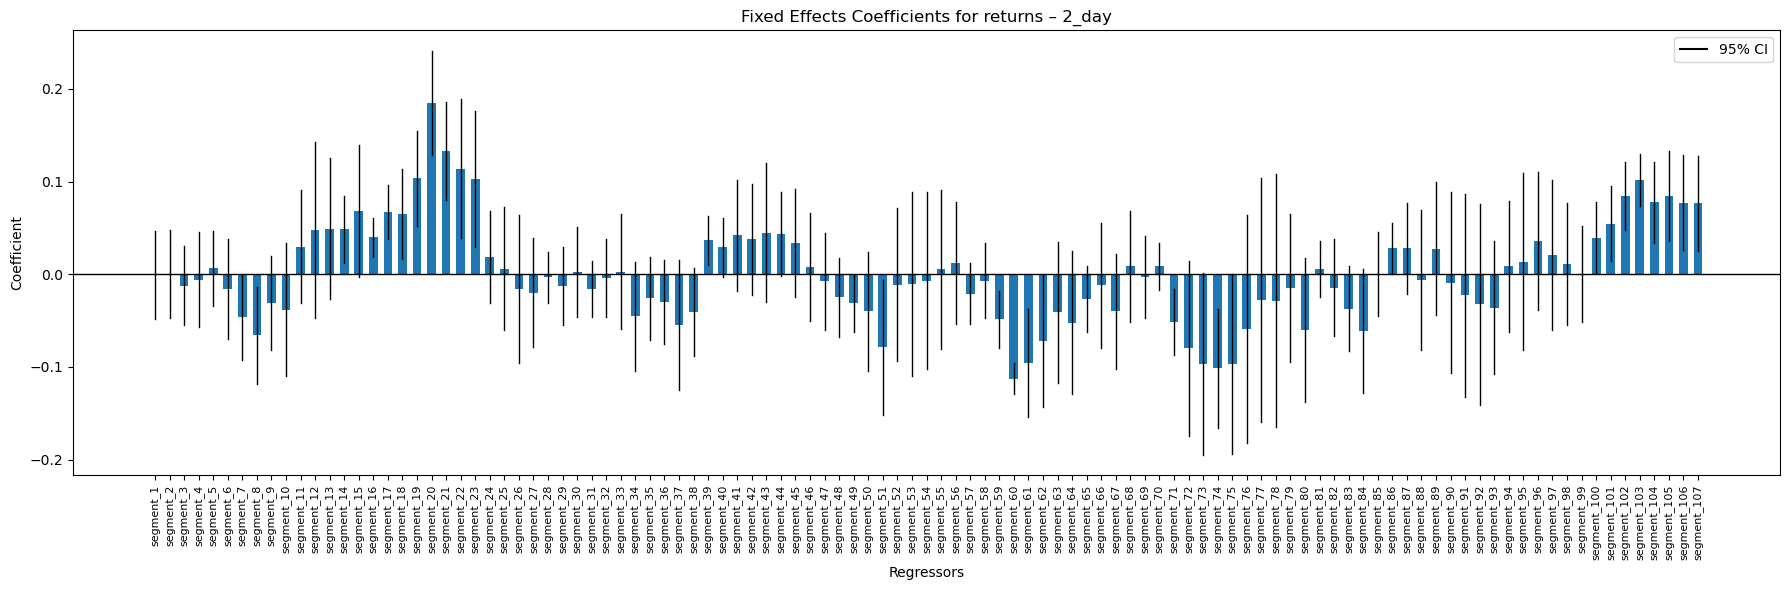

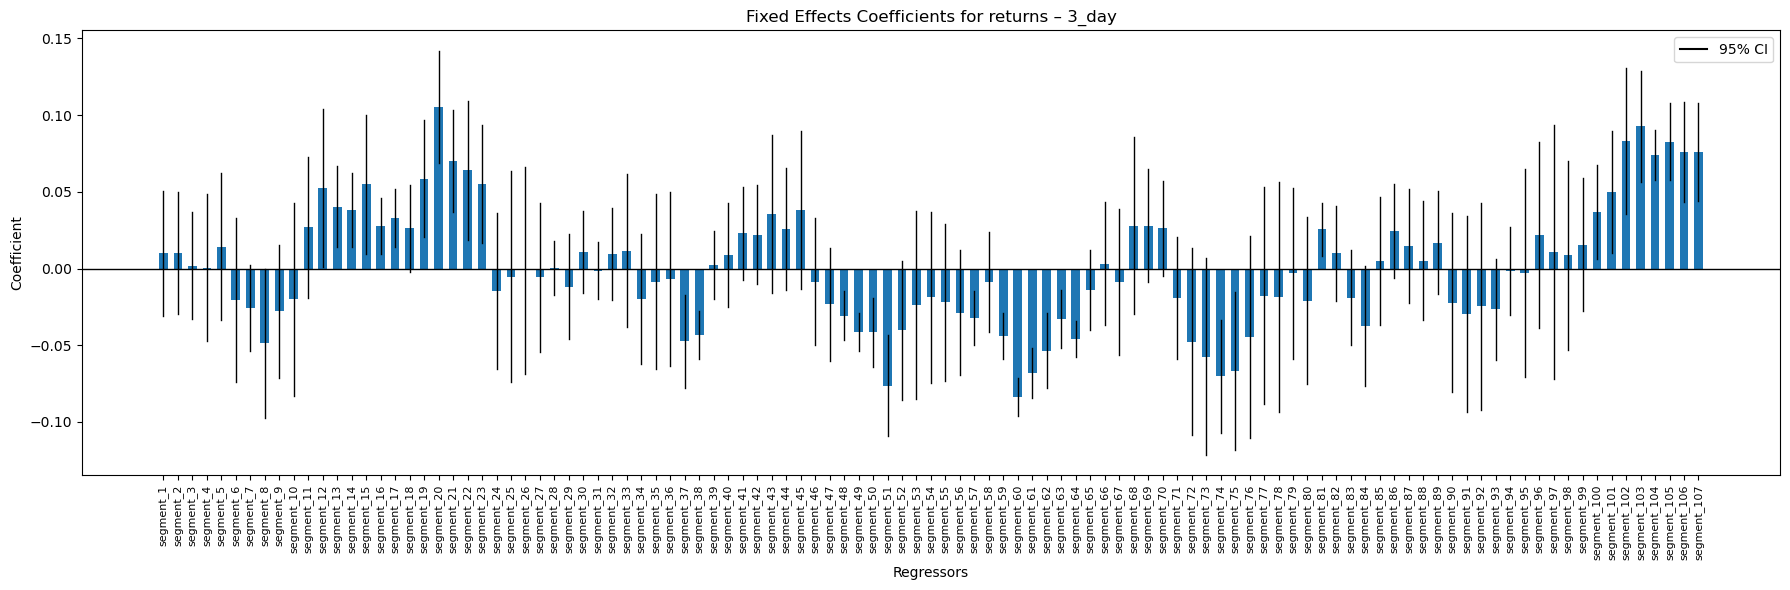

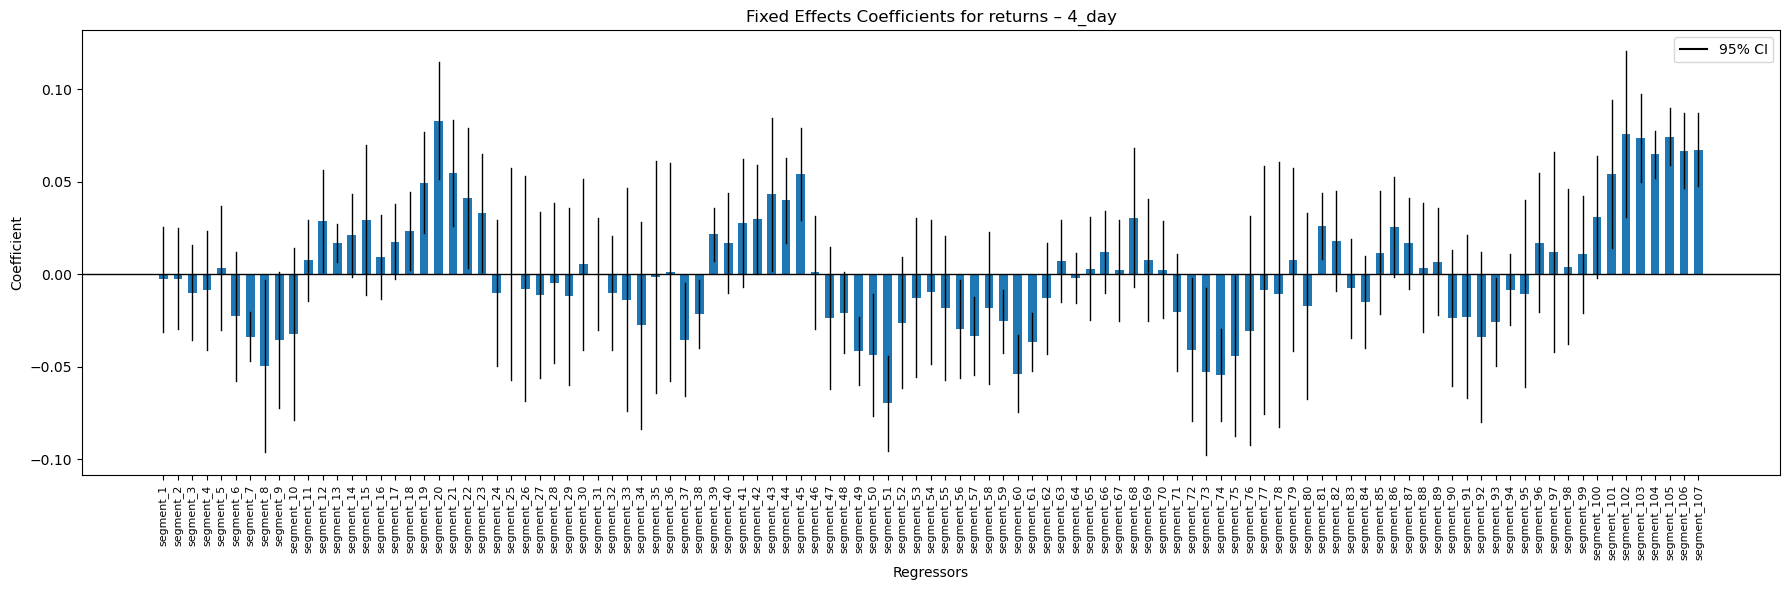

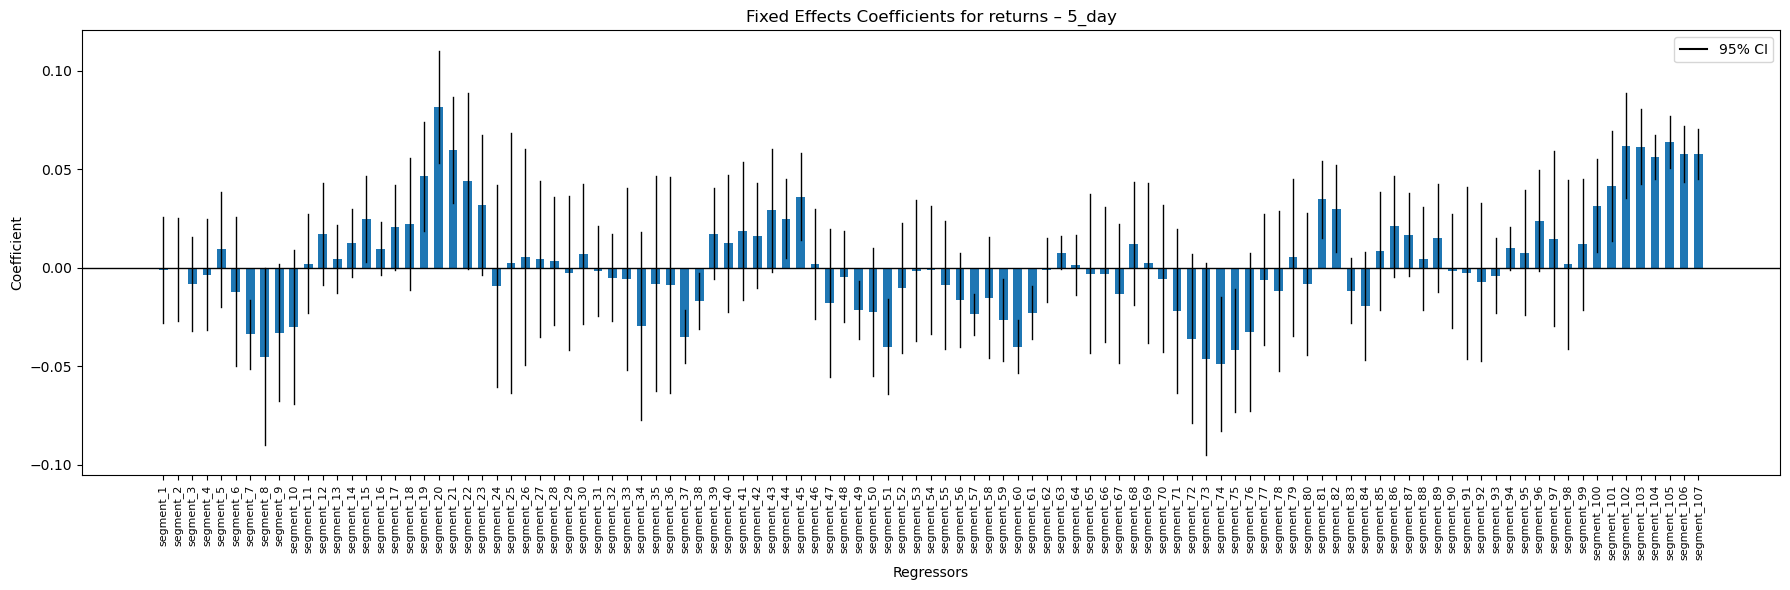

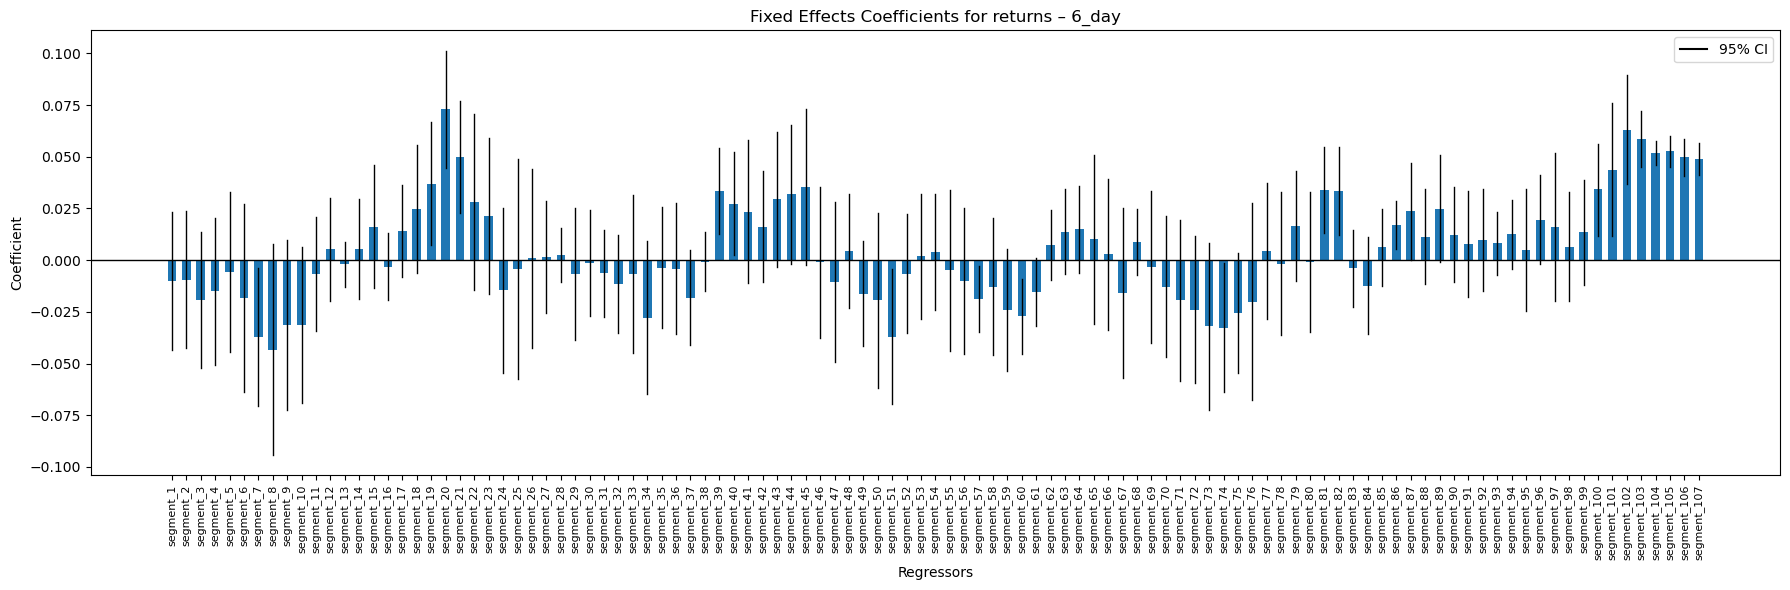

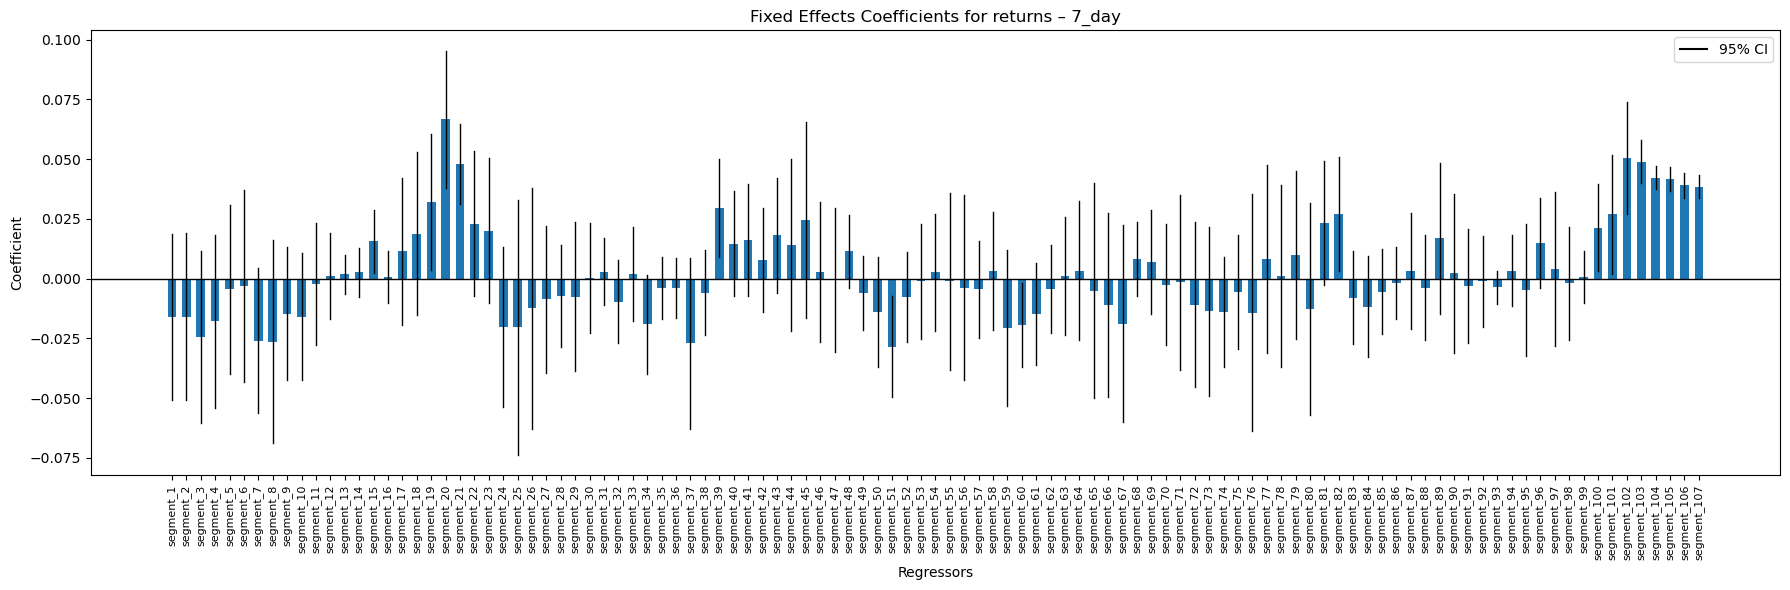

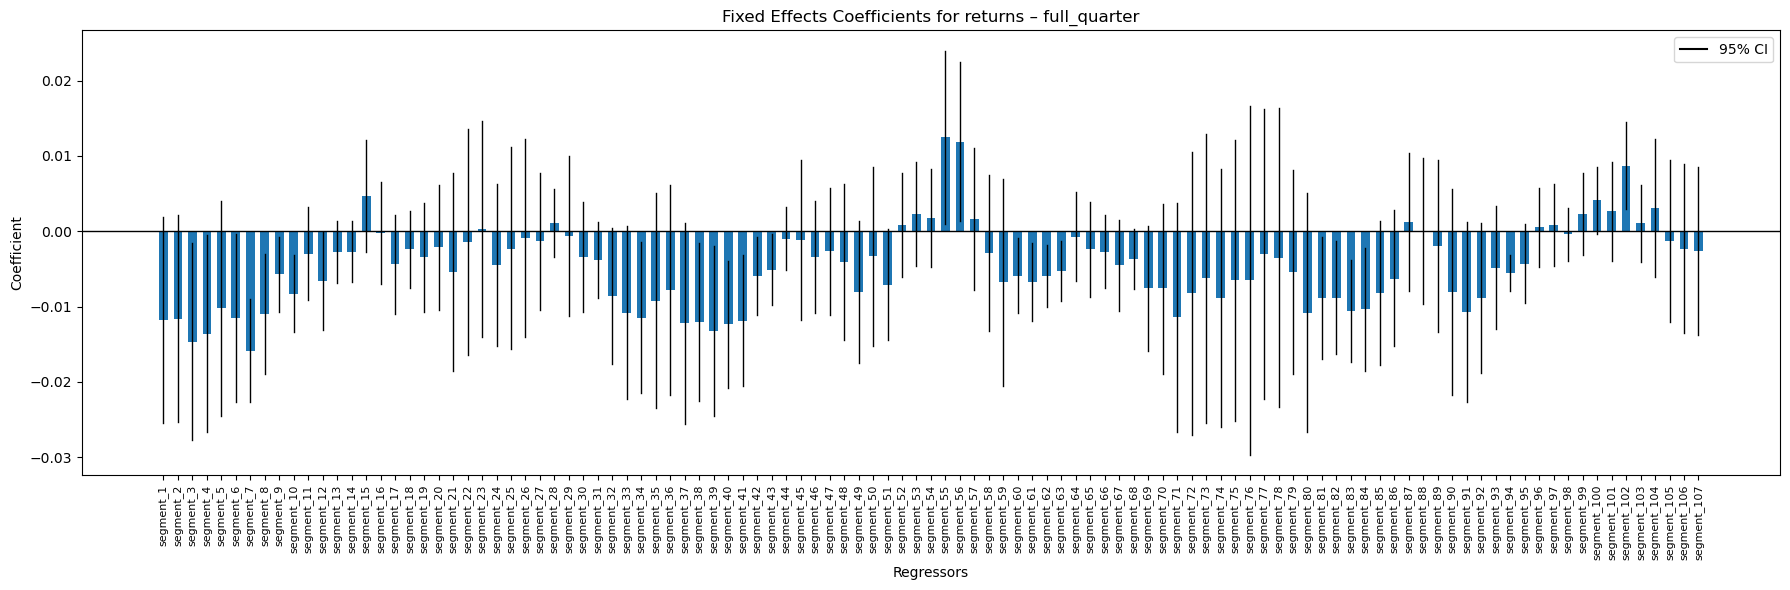

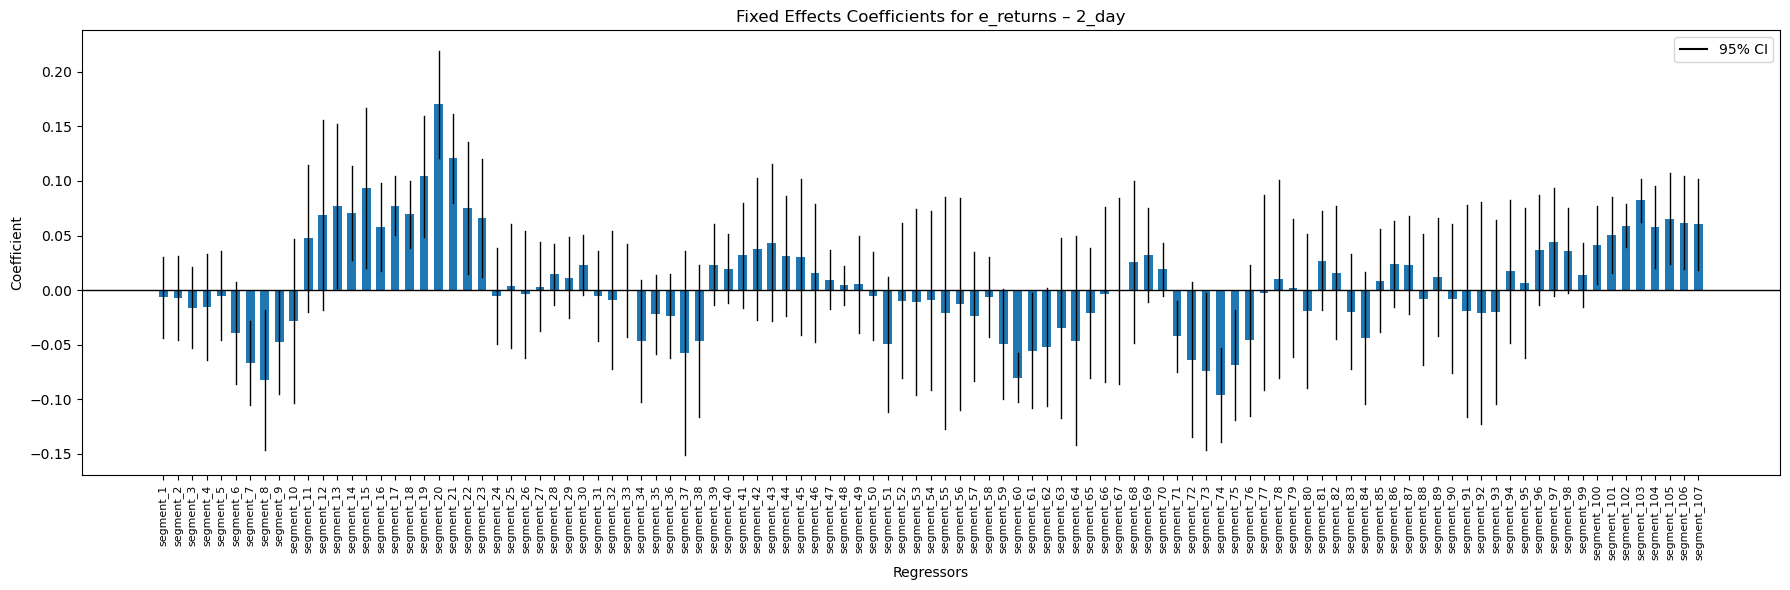

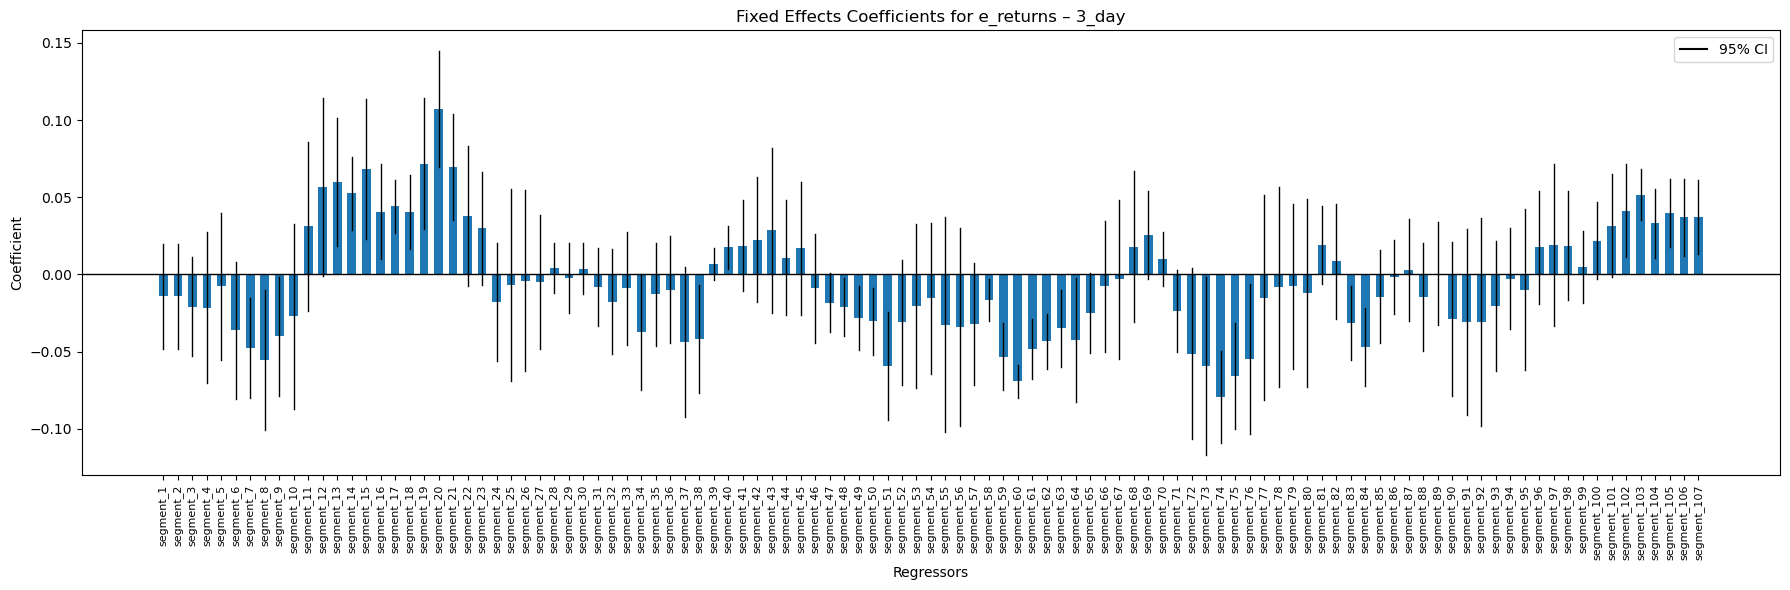

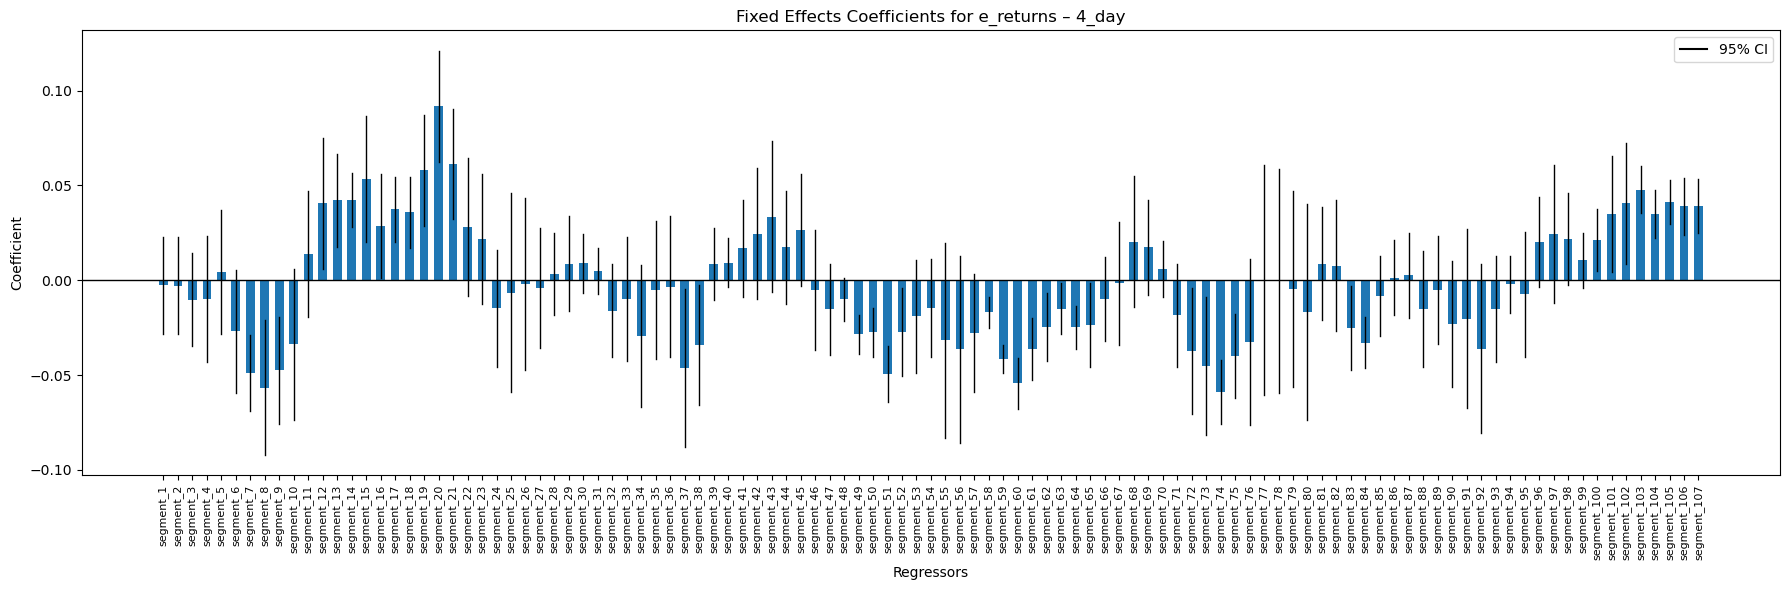

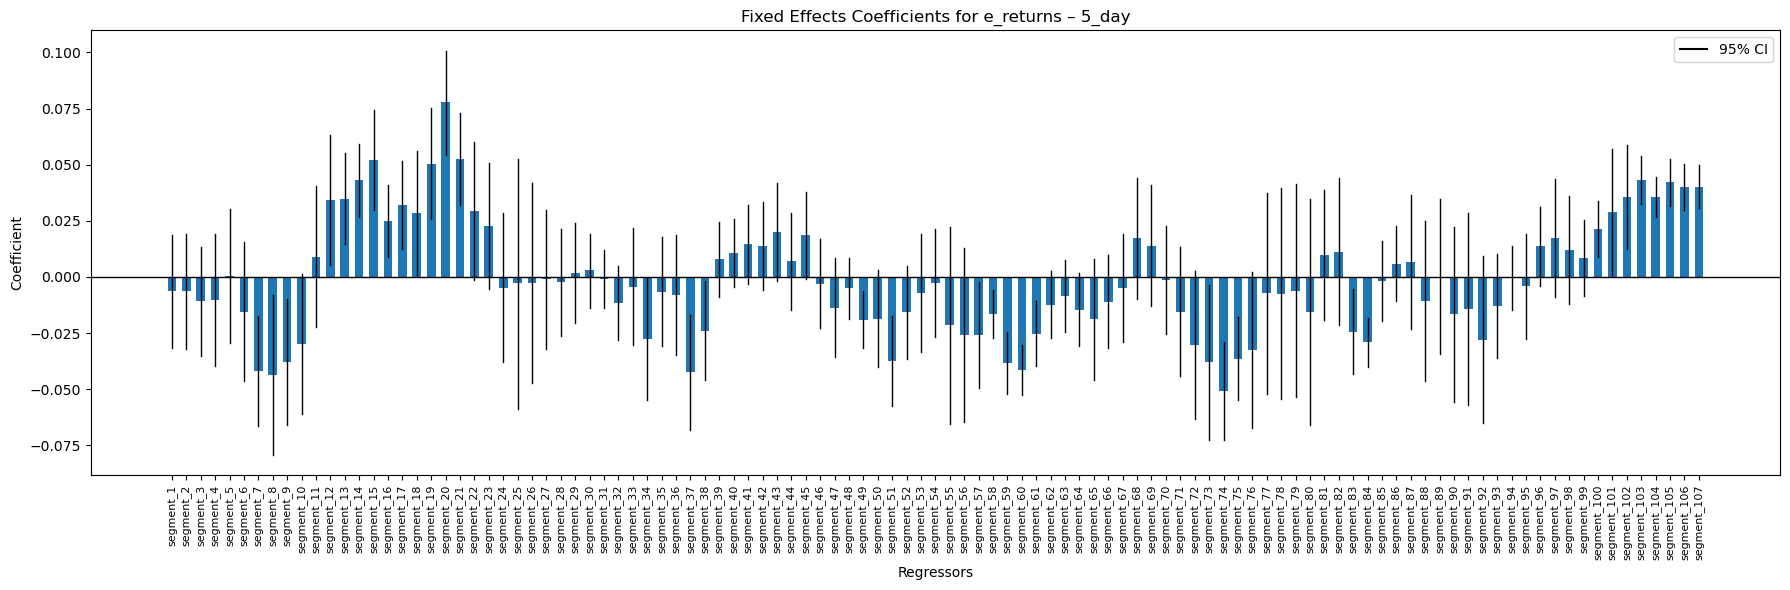

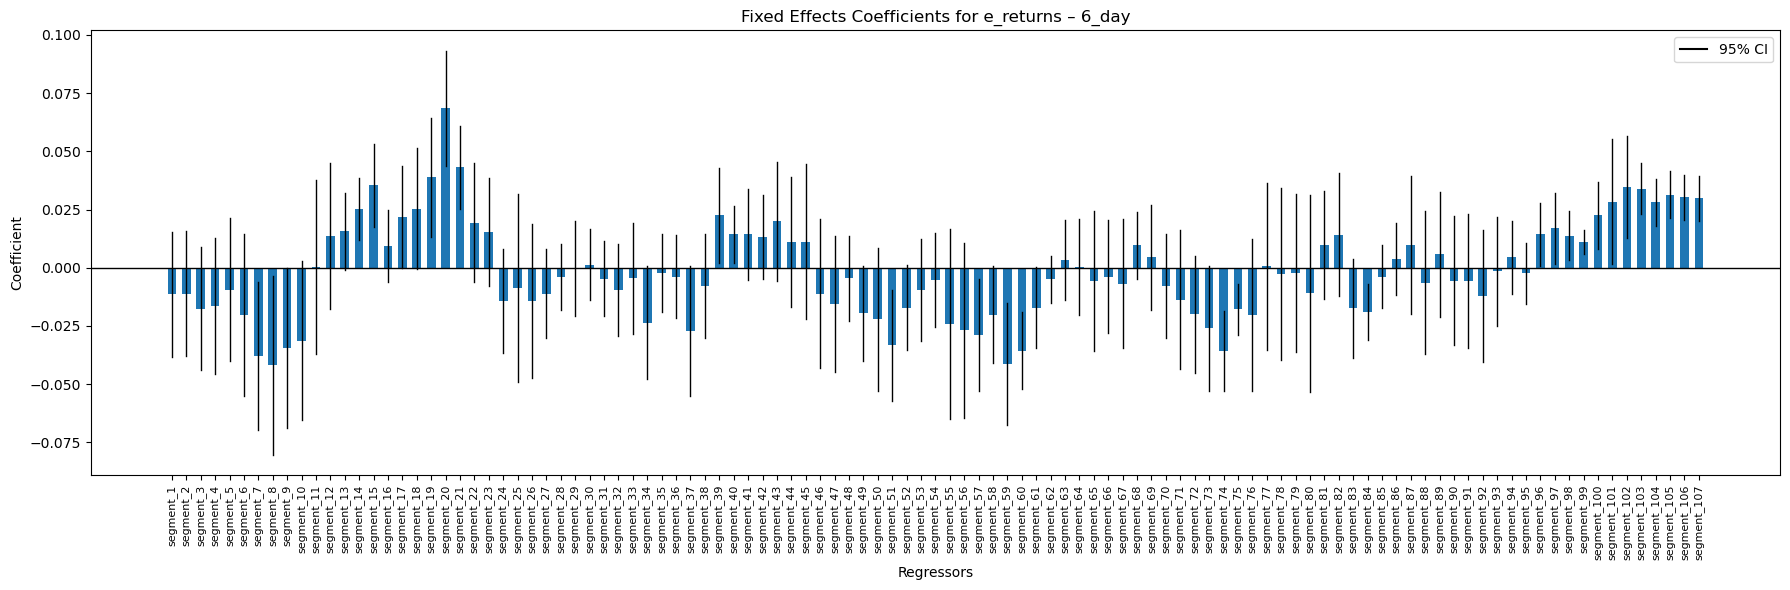

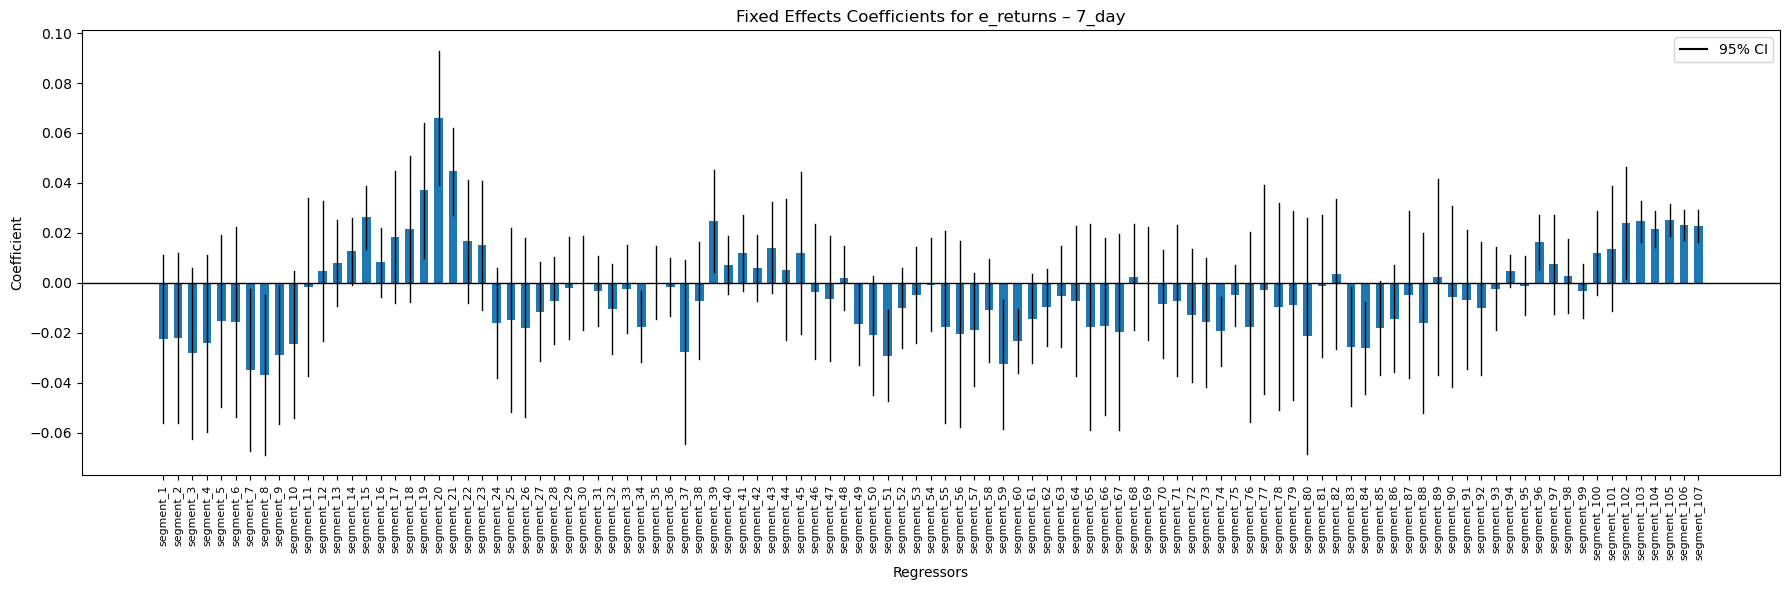

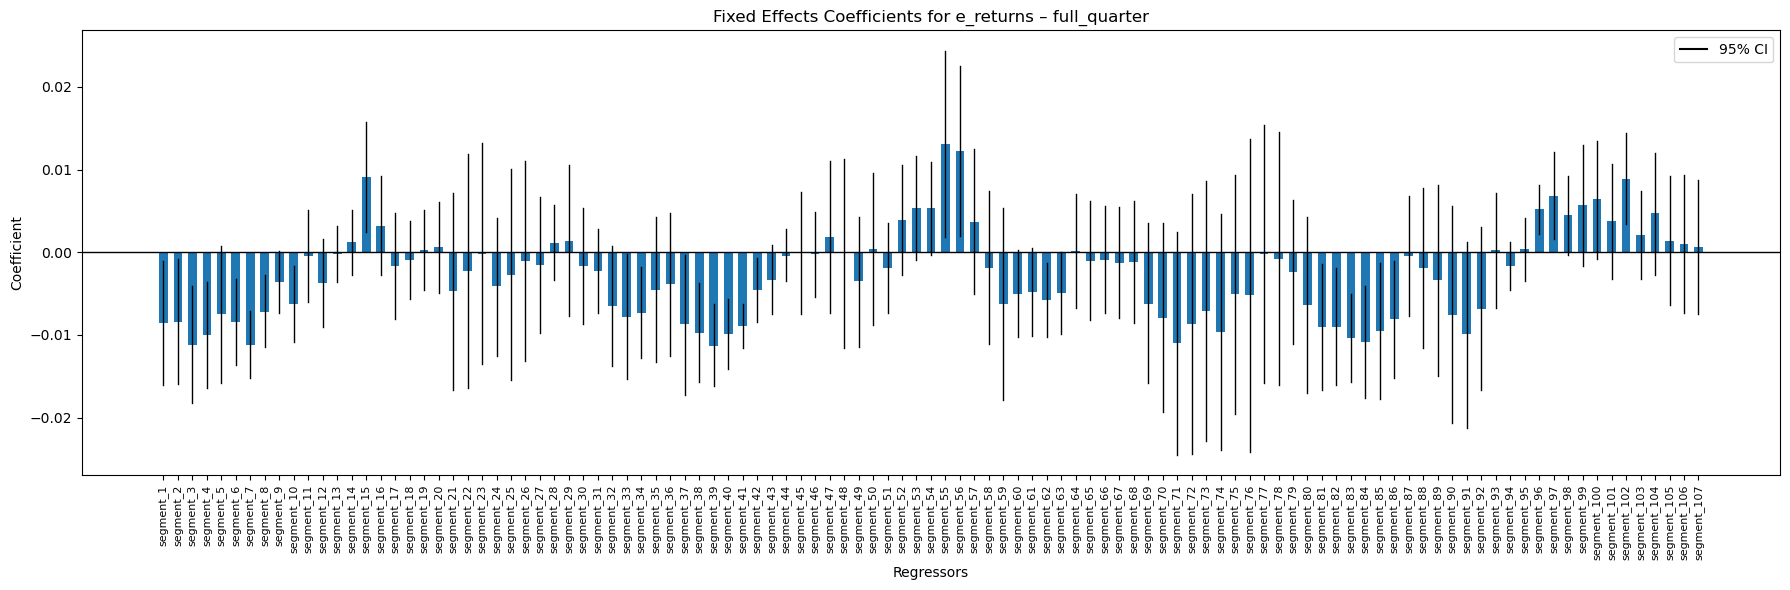

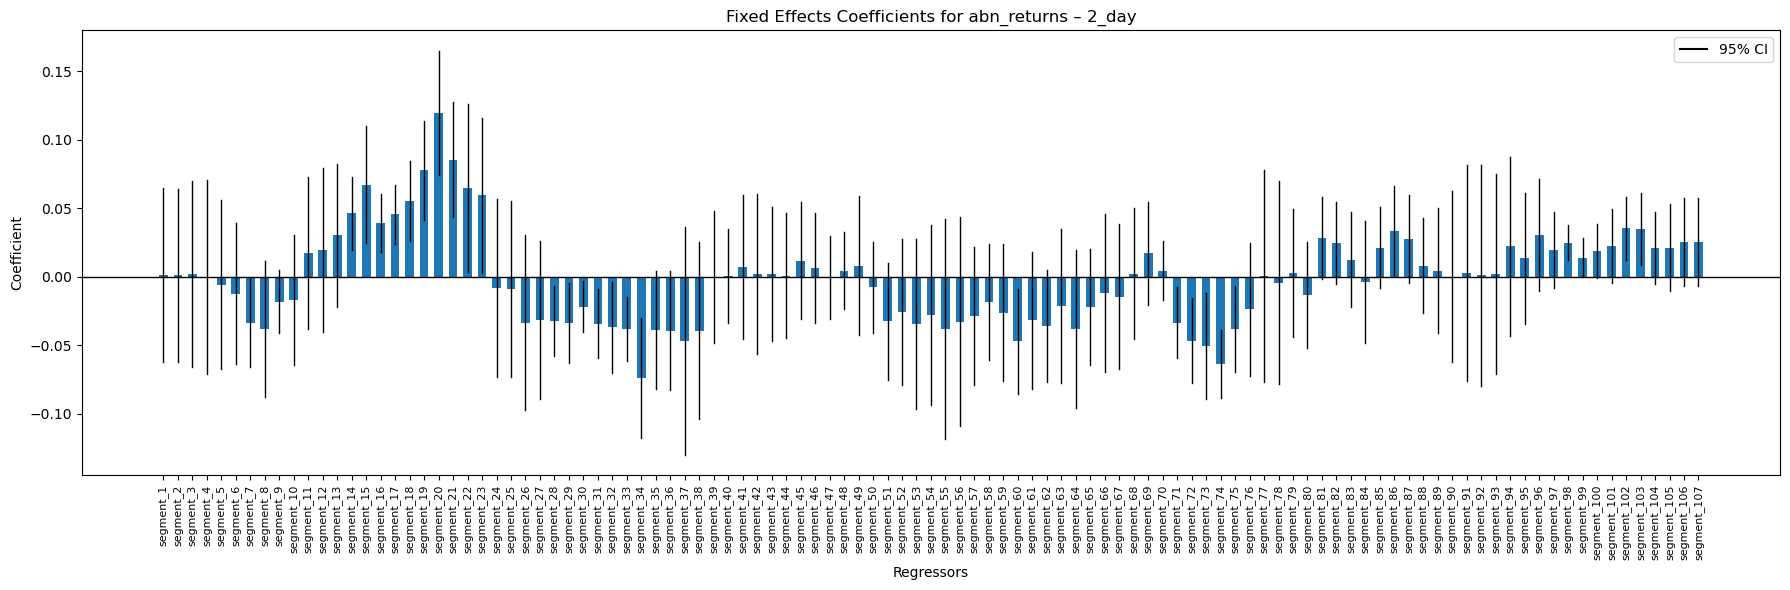

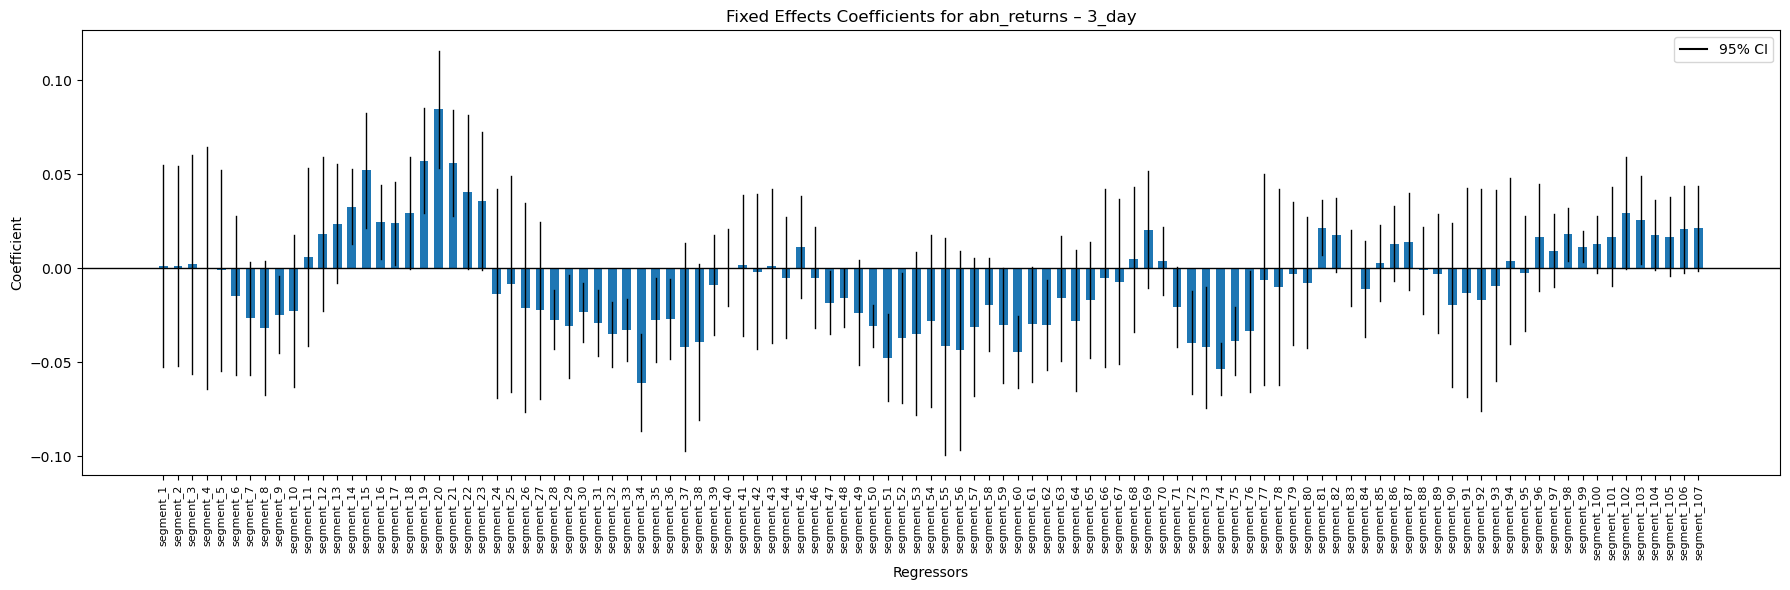

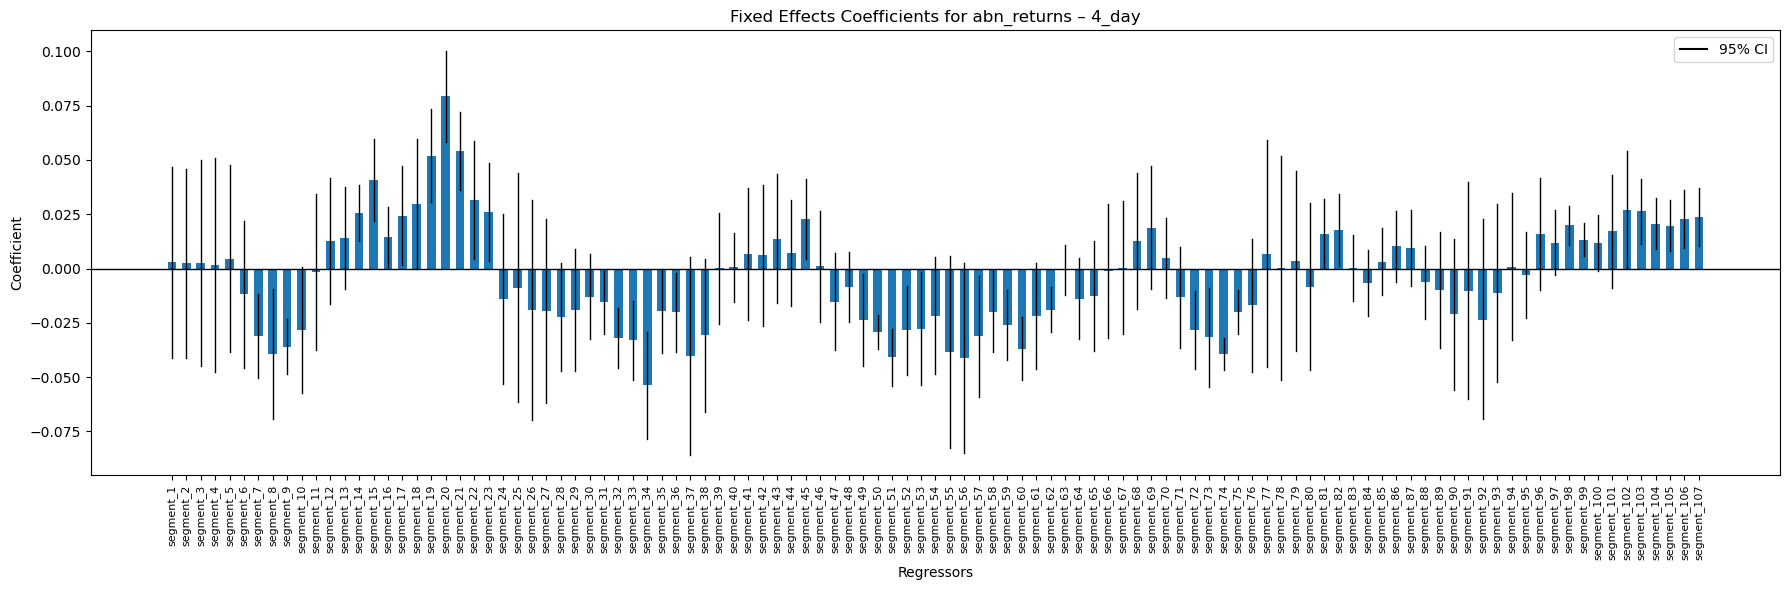

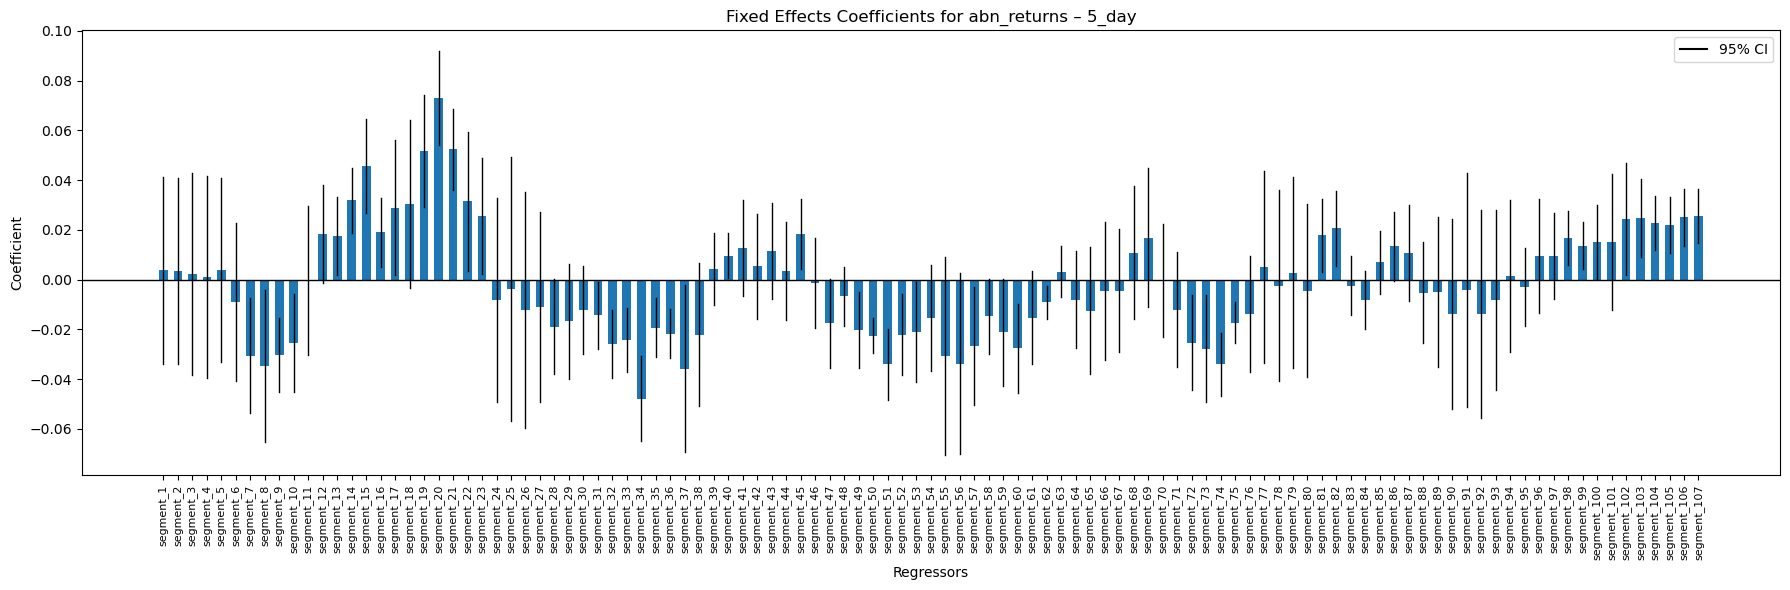

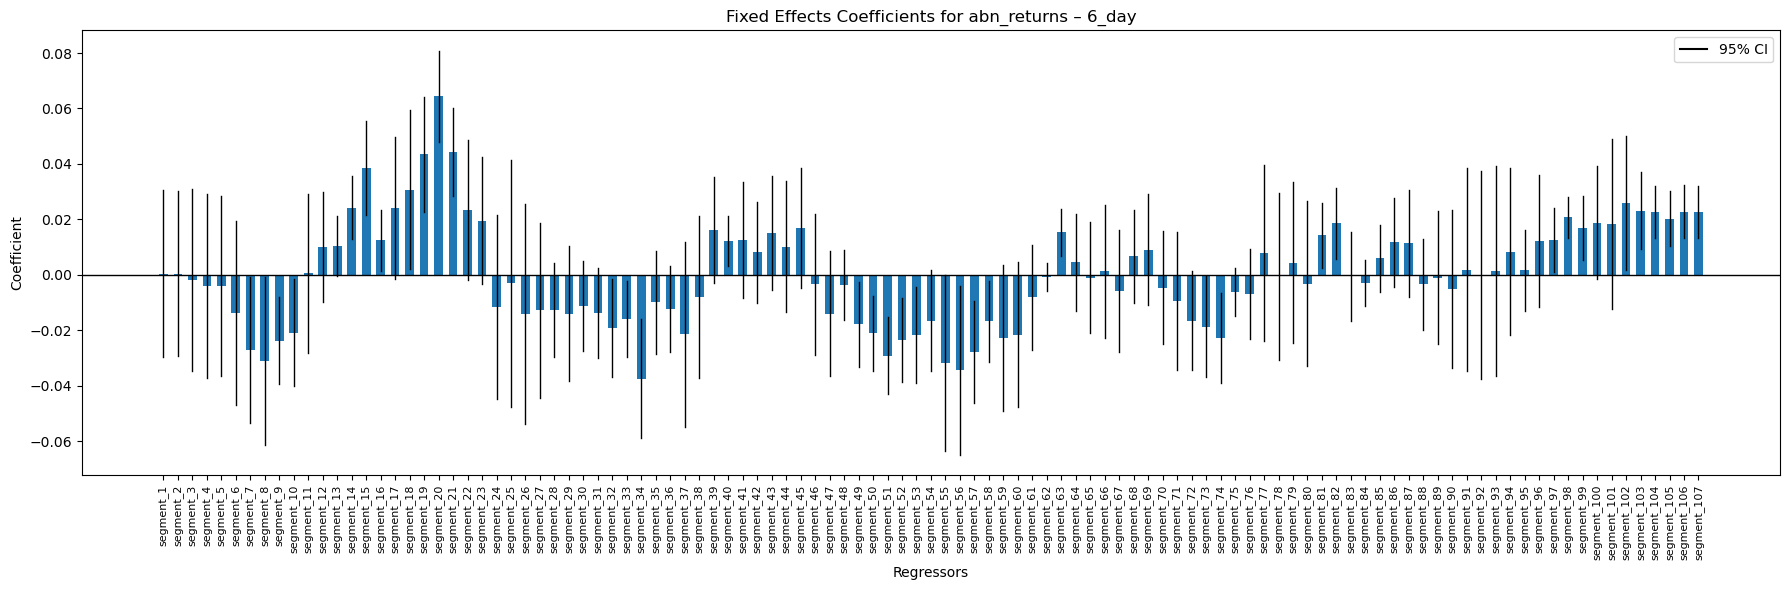

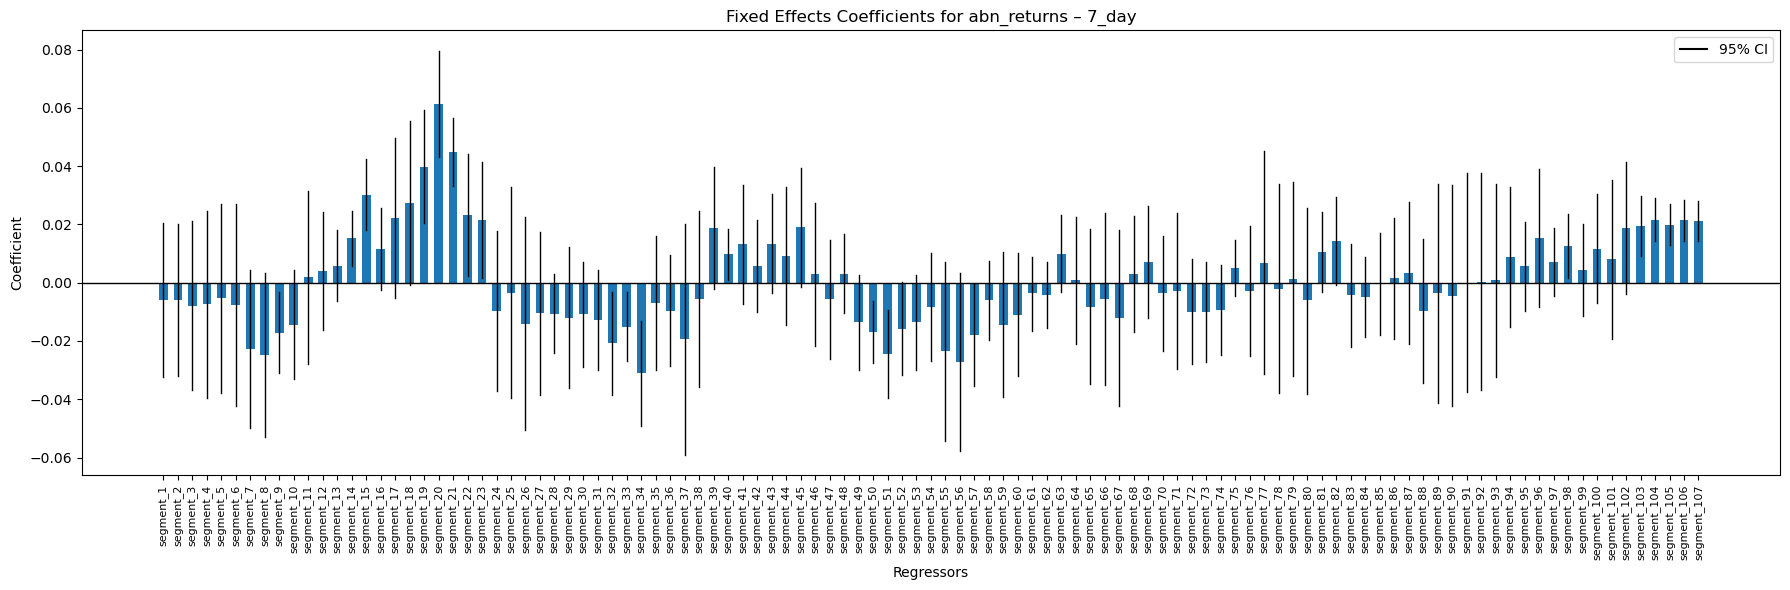

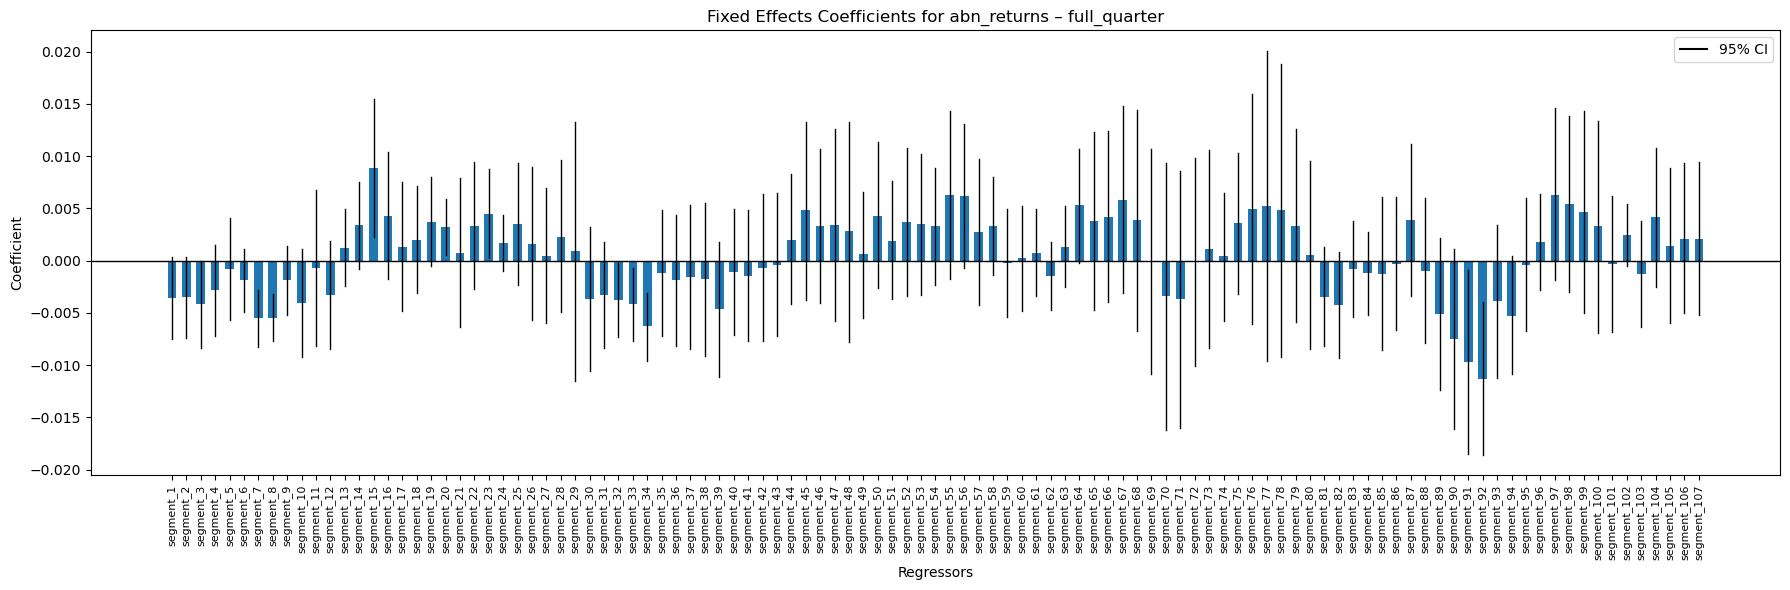

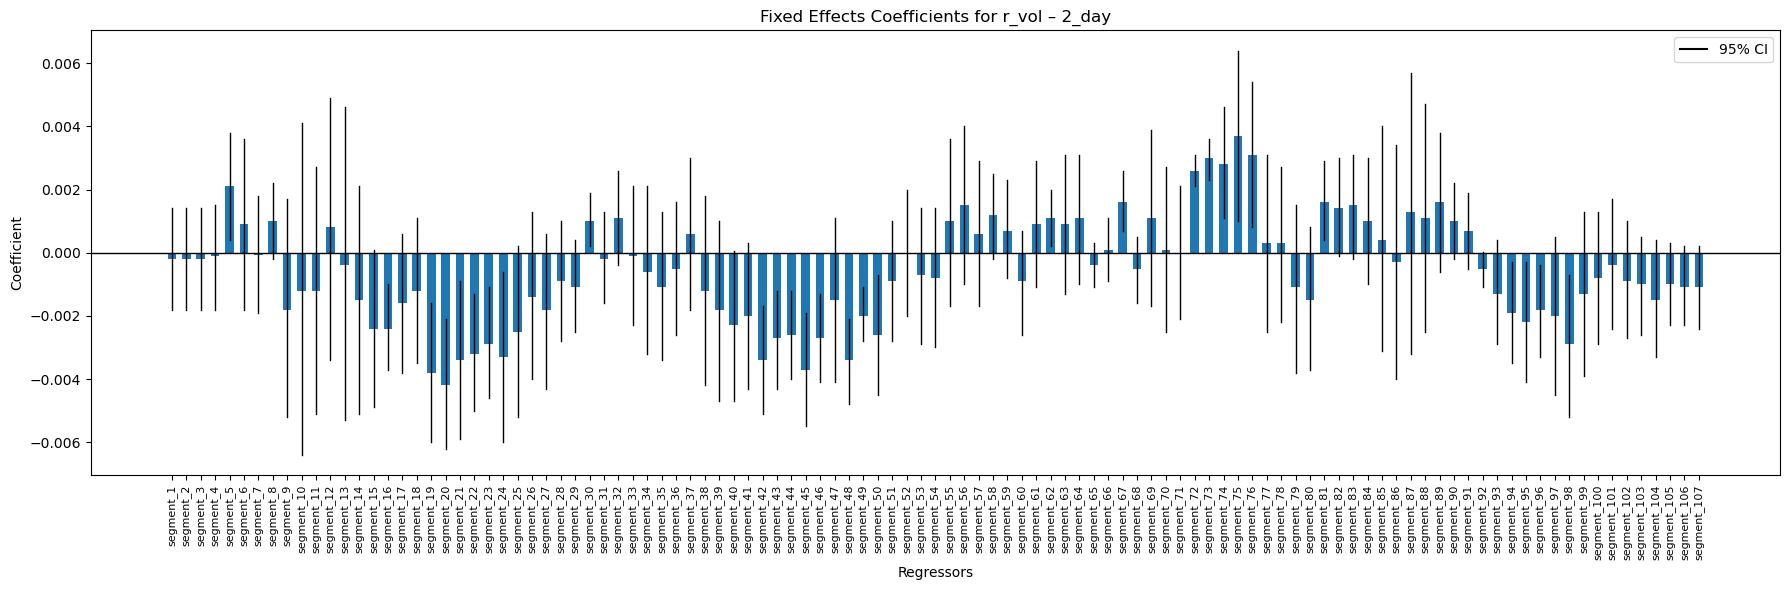

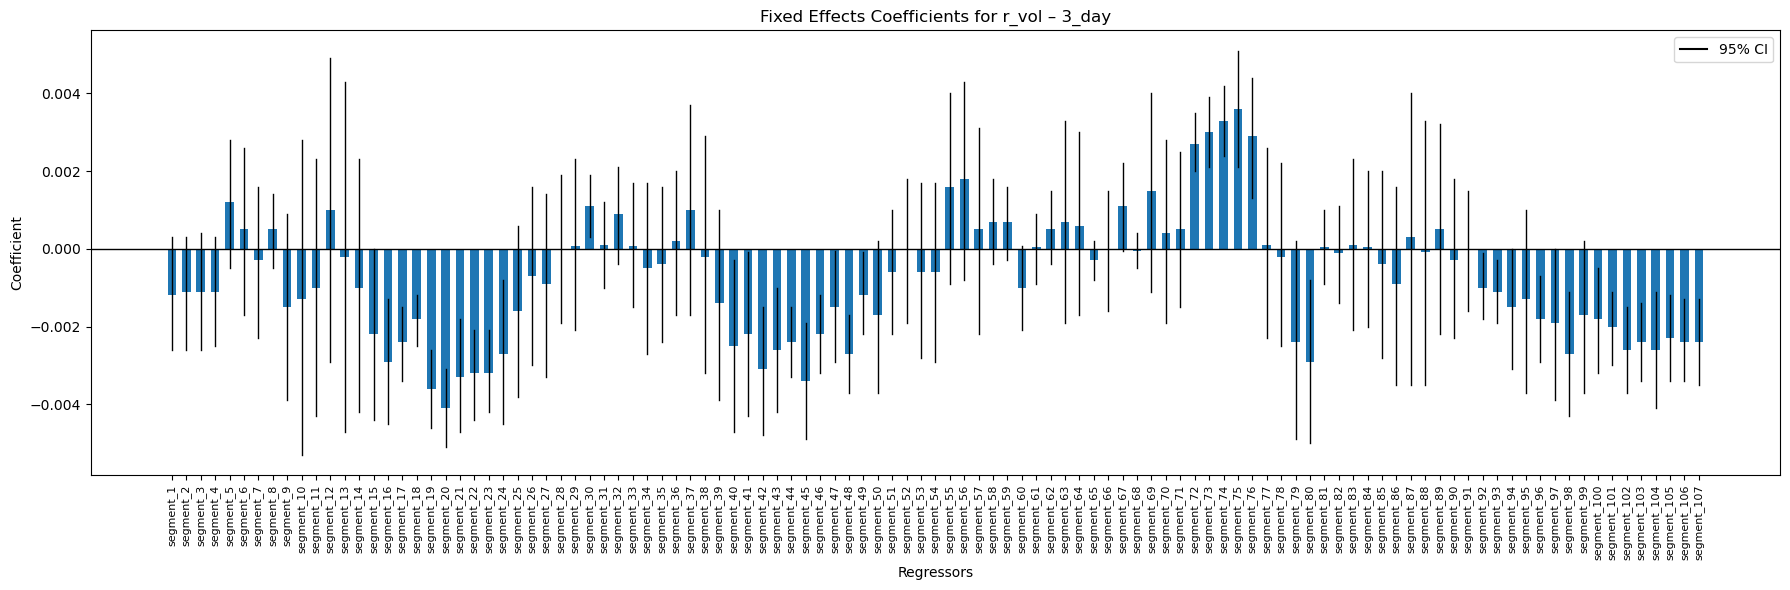

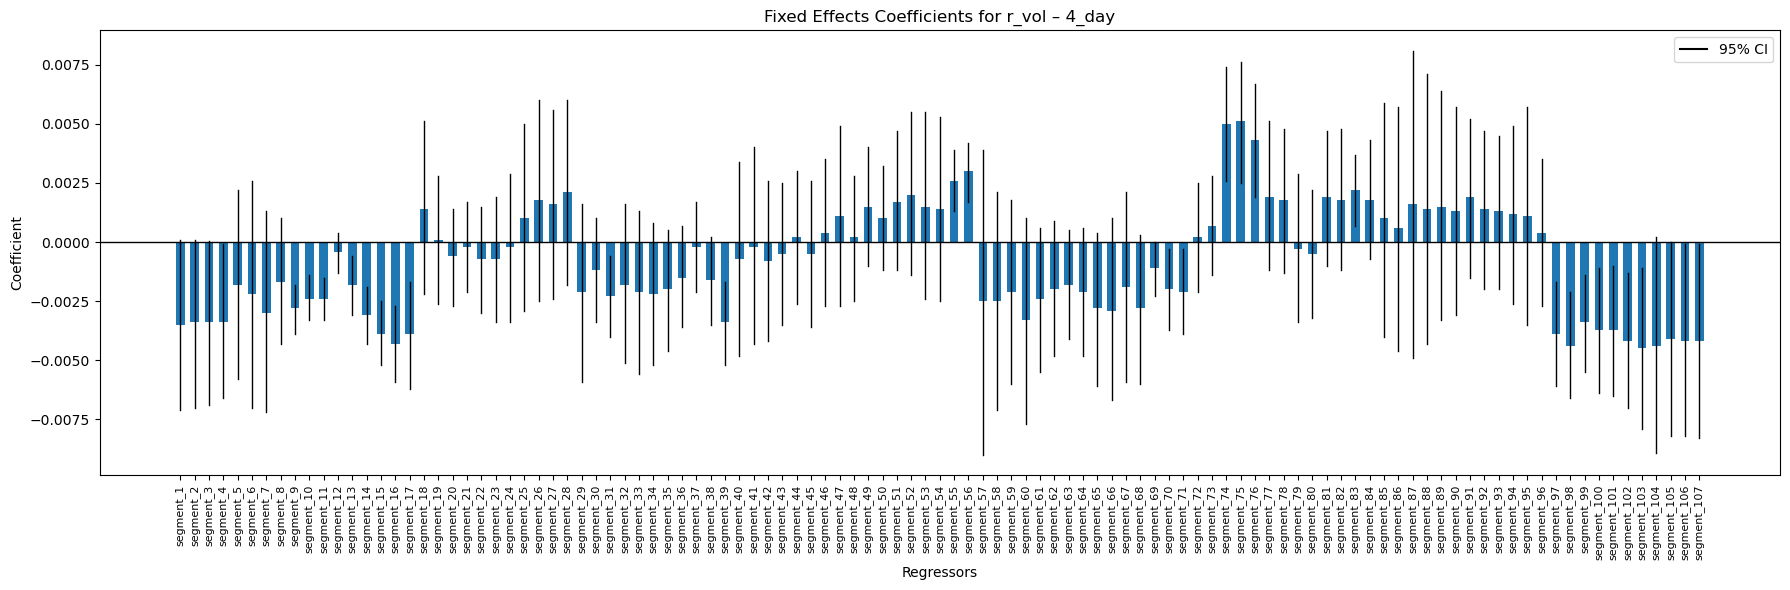

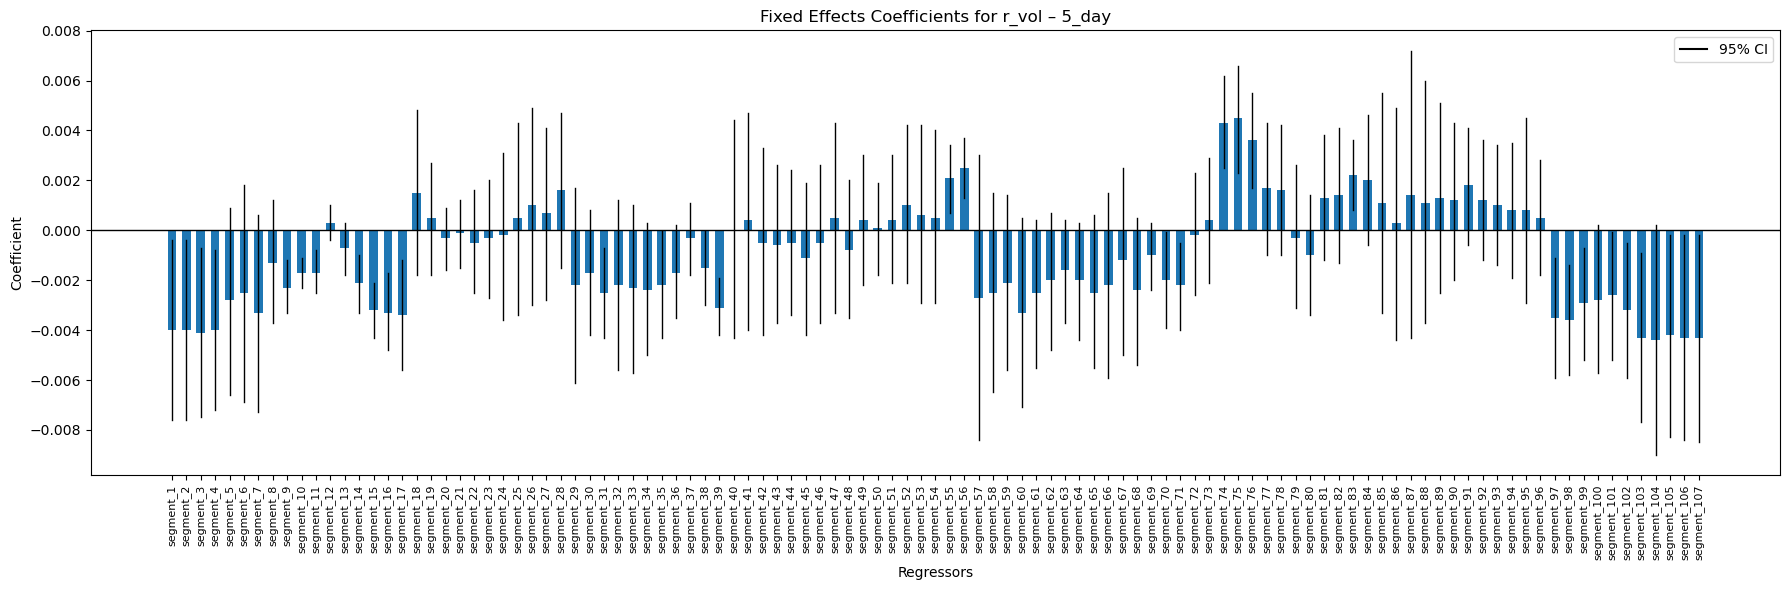

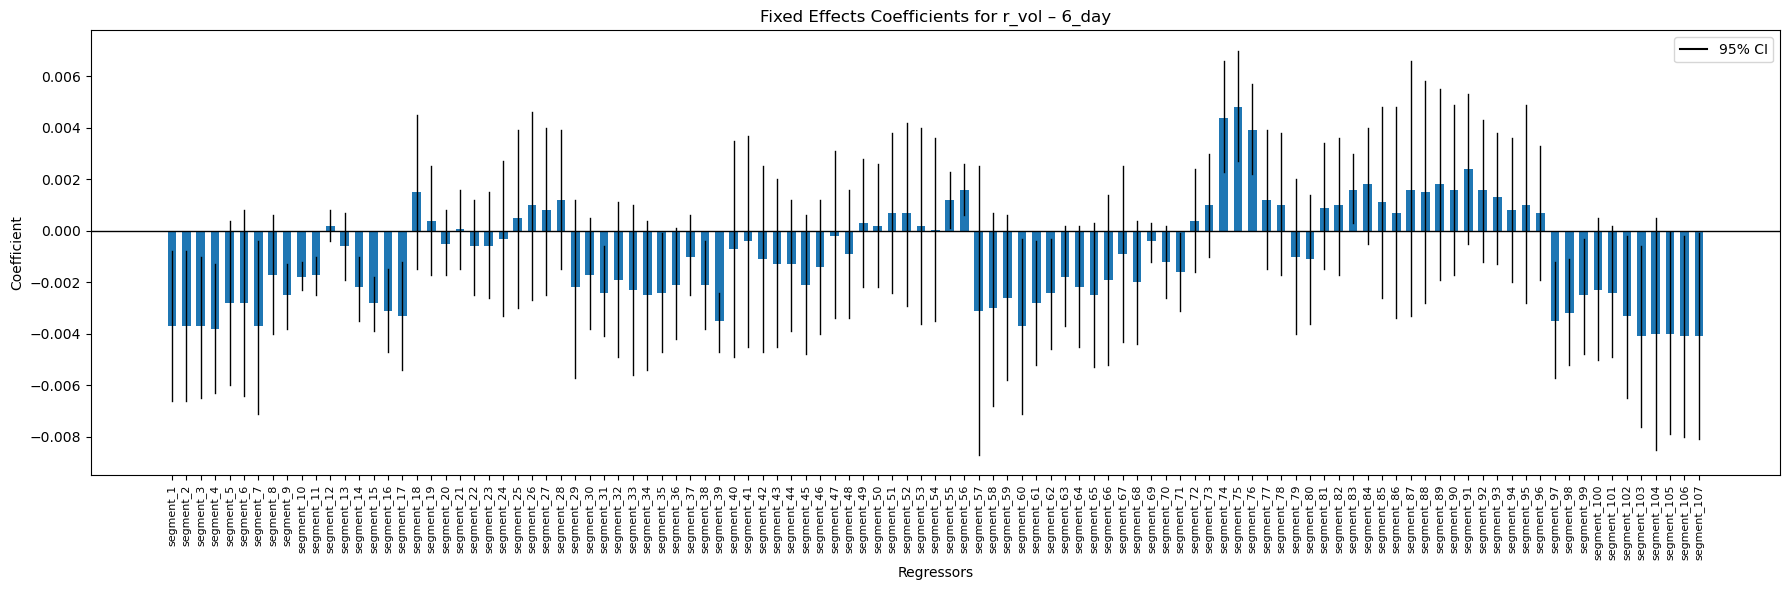

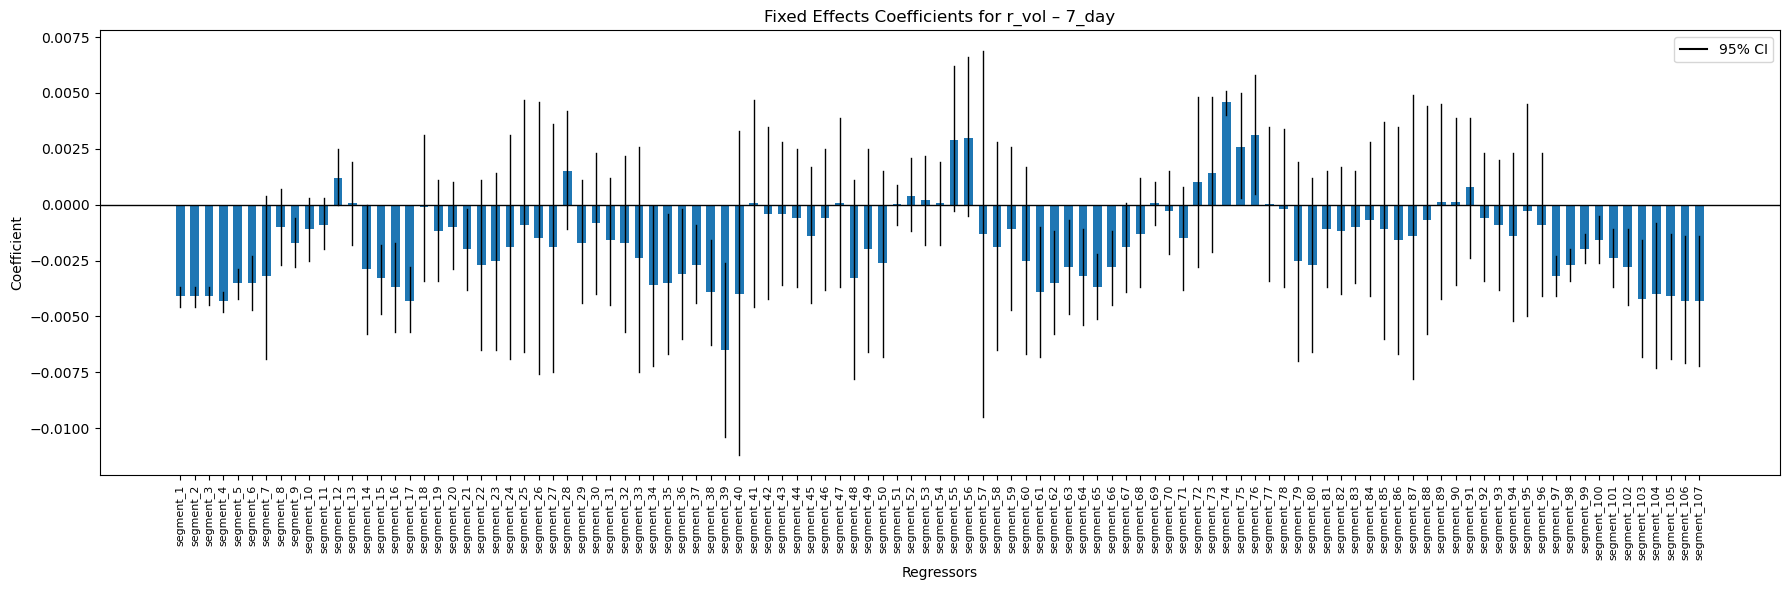

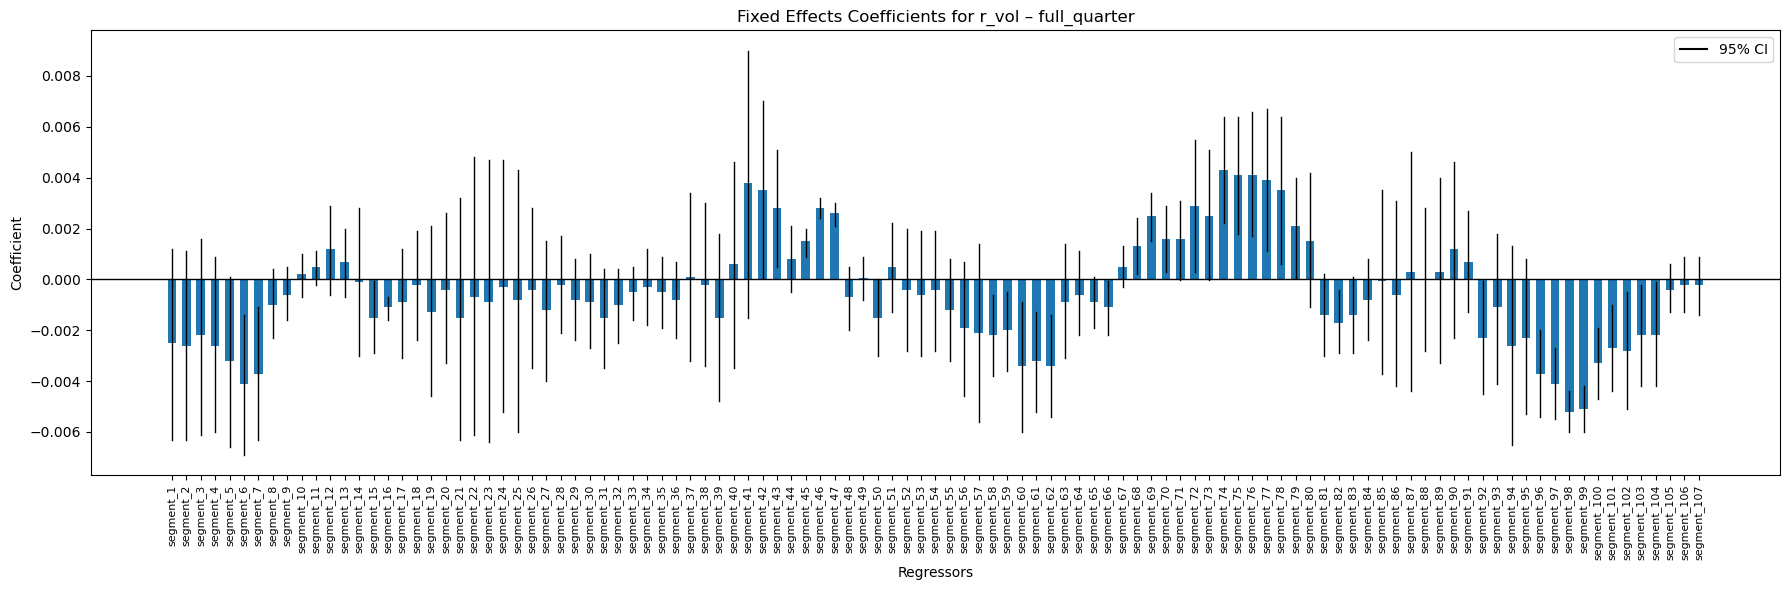

In [8]:
model.plot_all_params(save=True,dpi=100)